In [84]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, Aer
import networkx as nx
import numpy as np
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

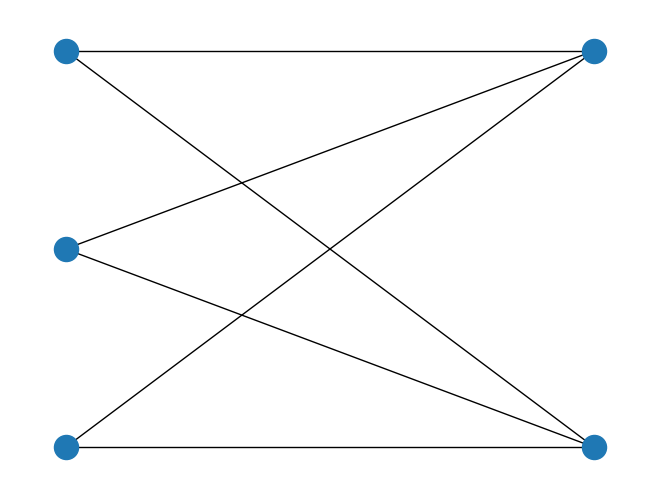

In [3]:
G = nx.Graph()
edges = [[0,3], [0,4], [1,3], [1,4], [2,3], [2,4]]
G.add_edges_from(edges)

nx.draw(G, pos = nx.bipartite_layout(G, [0,1,2]))

In [20]:
def append_zz(qc, q1, q2, gamma):
    qc.cx(q1, q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1, q2)

def build_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    
    return qc

In [21]:
qc = build_cost_operator_circuit(G, np.pi/3)
qc.draw()

»
q_0: ──■────────────────■────■────────────────────────────■─────────────────»
       │                │    │     ┌───┐    ┌──────────┐  │  ┌───┐     ┌───┐»
q_1: ──┼────────────────┼────┼─────┤ X ├────┤ Rz(2π/3) ├──┼──┤ X ├─────┤ X ├»
       │                │    │     └─┬─┘    └──────────┘  │  └─┬─┘┌───┐└─┬─┘»
q_2: ──┼────────────────┼────┼───────┼────────────────────┼────┼──┤ X ├──┼──»
     ┌─┴─┐┌──────────┐┌─┴─┐  │       │                    │    │  └─┬─┘  │  »
q_3: ┤ X ├┤ Rz(2π/3) ├┤ X ├──┼───────■────────────────────┼────■────■────┼──»
     └───┘└──────────┘└───┘┌─┴─┐┌──────────┐            ┌─┴─┐            │  »
q_4: ──────────────────────┤ X ├┤ Rz(2π/3) ├────────────┤ X ├────────────■──»
                           └───┘└──────────┘            └───┘               »
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                 
«q_0: ────────────────────────────────────────────
«     ┌──────────┐     ┌───┐                      
«q_1: ┤ Rz(2π/3) ├─────┤ X ├──────────────────────
«     ├──────────┤┌───┐└─┬─┘┌───┐┌──────────┐┌───┐
«q_2: ┤ Rz(2π/3) ├┤ X ├──┼──┤ X ├┤ Rz(2π/3) ├┤ X ├
«     └──────────┘└─┬─┘  │  └─┬─┘└──────────┘└─┬─┘
«q_3: ──────────────■────┼────┼────────────────┼──
«                        │    │                │  
«q_4: ───────────────────■────■────────────────■──
«                                                 
«c: 5/════════════════════════════════════════════
«

In [22]:
def append_x(qc, q1, beta):
    qc.rx(2*beta, q1)

def build_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x(qc, n, beta)
    return qc

In [23]:
qc = build_mixer_operator_circuit(G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ Rx(2π/3) ├
     ├──────────┤
q_1: ┤ Rx(2π/3) ├
     ├──────────┤
q_2: ┤ Rx(2π/3) ├
     ├──────────┤
q_3: ┤ Rx(2π/3) ├
     ├──────────┤
q_4: ┤ Rx(2π/3) ├
     └──────────┘
c: 5/════════════

In [65]:
def build_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)

    qc.h(range(N))

    for i in range(p):
        qc.barrier()
        for j, k in G.edges():
            append_zz(qc, j, k, gamma[i])
        qc.barrier()
        for n in G.nodes():
            append_x(qc, n, beta[i])

    qc.measure(range(N), range(N))
    return qc
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [69]:
def no_of_cuts(x, G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            cut += 1
    return cut

In [70]:
def compute_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        cuts = no_of_cuts(meas, G)
        energy += -1 * cuts * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_energy(invert_counts(counts), G)

-3.0029296875

In [79]:
def black_box_obj(G, p):
    simulator = AerSimulator(method="statevector", device="GPU")
    def f(theta):
        beta = theta[:p]
        gamma = theta[p:]
        qc = build_qaoa_circuit(G, beta, gamma)
        counts = simulator.run(qc, shots=1024).result().get_counts()

        return compute_energy(invert_counts(counts), G)
    return f

In [80]:
p = 5
obj = black_box_obj(G, p)
init_point = np.array([0.8, 2.2, 0.3,2.1,0.3,2.4,6.1,2.2,3.8,6.1])
sample = minimize(obj, init_point, method='COBYLA', options={'maxiter': 2500, 'disp': True})
sample


   Normal return from subroutine COBYLA

   NFVALS =  117   F =-5.809570E+00    MAXCV = 0.000000E+00
   X = 1.829539E+00   2.220806E+00   2.559170E-01   2.058905E+00   3.247428E-01
       2.494799E+00   6.044726E+00   2.145363E+00   3.767020E+00   6.211092E+00


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.8095703125
       x: [ 1.830e+00  2.221e+00  2.559e-01  2.059e+00  3.247e-01
            2.495e+00  6.045e+00  2.145e+00  3.767e+00  6.211e+00]
    nfev: 117
   maxcv: 0.0

In [85]:
optimal_theta = sample['x']
qc = build_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(simulator.run(qc, shots=1024).result().get_counts())
counts

{'10100': 17,
 '10011': 12,
 '00111': 17,
 '00010': 1,
 '00100': 1,
 '11111': 3,
 '00000': 3,
 '01100': 14,
 '01011': 13,
 '11000': 18,
 '11100': 452,
 '00011': 473}

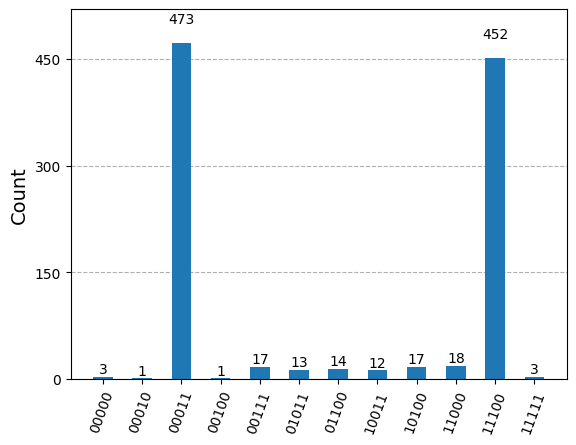

In [86]:
plot_histogram(counts)

In [92]:
qc.draw()

┌───┐ ░                                                                »
q_0: ┤ H ├─░───■───────────────■────■──────────────────────────■────────────»
     ├───┤ ░   │               │    │     ┌───┐   ┌─────────┐  │  ┌───┐     »
q_1: ┤ H ├─░───┼───────────────┼────┼─────┤ X ├───┤ Rz(π/2) ├──┼──┤ X ├─────»
     ├───┤ ░   │               │    │     └─┬─┘   └─────────┘  │  └─┬─┘┌───┐»
q_2: ┤ H ├─░───┼───────────────┼────┼───────┼──────────────────┼────┼──┤ X ├»
     ├───┤ ░ ┌─┴─┐┌─────────┐┌─┴─┐  │       │                  │    │  └─┬─┘»
q_3: ┤ H ├─░─┤ X ├┤ Rz(π/2) ├┤ X ├──┼───────■──────────────────┼────■────■──»
     ├───┤ ░ └───┘└─────────┘└───┘┌─┴─┐┌─────────┐           ┌─┴─┐          »
q_4: ┤ H ├─░──────────────────────┤ X ├┤ Rz(π/2) ├───────────┤ X ├──────────»
     └───┘ ░                      └───┘└─────────┘           └───┘          »
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                     ░ ┌──────────┐ ░      »
«q_0: ────────────────────────────────────────────────░─┤ Rx(2π/3) ├─░───■──»
«     ┌───┐┌─────────┐     ┌───┐                      ░ ├──────────┤ ░   │  »
«q_1: ┤ X ├┤ Rz(π/2) ├─────┤ X ├──────────────────────░─┤ Rx(2π/3) ├─░───┼──»
«     └─┬─┘├─────────┤┌───┐└─┬─┘┌───┐┌─────────┐┌───┐ ░ ├──────────┤ ░   │  »
«q_2: ──┼──┤ Rz(π/2) ├┤ X ├──┼──┤ X ├┤ Rz(π/2) ├┤ X ├─░─┤ Rx(2π/3) ├─░───┼──»
«       │  └─────────┘└─┬─┘  │  └─┬─┘└─────────┘└─┬─┘ ░ ├──────────┤ ░ ┌─┴─┐»
«q_3: ──┼───────────────■────┼────┼───────────────┼───░─┤ Rx(2π/3) ├─░─┤ X ├»
«       │                    │    │               │   ░ ├──────────┤ ░ └───┘»
«q_4: ──■────────────────────■────■───────────────■───░─┤ Rx(2π/3) ├─░──────»
«                                                     ░ └──────────┘ ░      »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                    »
«q_0: ─────────────■────■──────────────────────────■─────────────────»
«                  │    │     ┌───┐   ┌─────────┐  │  ┌───┐     ┌───┐»
«q_1: ─────────────┼────┼─────┤ X ├───┤ Rz(π/2) ├──┼──┤ X ├─────┤ X ├»
«                  │    │     └─┬─┘   └─────────┘  │  └─┬─┘┌───┐└─┬─┘»
«q_2: ─────────────┼────┼───────┼──────────────────┼────┼──┤ X ├──┼──»
«     ┌─────────┐┌─┴─┐  │       │                  │    │  └─┬─┘  │  »
«q_3: ┤ Rz(π/2) ├┤ X ├──┼───────■──────────────────┼────■────■────┼──»
«     └─────────┘└───┘┌─┴─┐┌─────────┐           ┌─┴─┐            │  »
«q_4: ────────────────┤ X ├┤ Rz(π/2) ├───────────┤ X ├────────────■──»
«                     └───┘└─────────┘           └───┘               »
«c: 5/═══════════════════════════════════════════════════════════════»
«                                                                    »
«                                                ░ ┌──────────┐┌─┐            
«q_0: ───────────────────────────────────────────░─┤ Rx(2π/3) ├┤M├────────────
«     ┌─────────┐     ┌───┐                      ░ ├──────────┤└╥┘┌─┐         
«q_1: ┤ Rz(π/2) ├─────┤ X ├──────────────────────░─┤ Rx(2π/3) ├─╫─┤M├─────────
«     ├─────────┤┌───┐└─┬─┘┌───┐┌─────────┐┌───┐ ░ ├──────────┤ ║ └╥┘┌─┐      
«q_2: ┤ Rz(π/2) ├┤ X ├──┼──┤ X ├┤ Rz(π/2) ├┤ X ├─░─┤ Rx(2π/3) ├─╫──╫─┤M├──────
«     └─────────┘└─┬─┘  │  └─┬─┘└─────────┘└─┬─┘ ░ ├──────────┤ ║  ║ └╥┘┌─┐   
«q_3: ─────────────■────┼────┼───────────────┼───░─┤ Rx(2π/3) ├─╫──╫──╫─┤M├───
«                       │    │               │   ░ ├──────────┤ ║  ║  ║ └╥┘┌─┐
«q_4: ──────────────────■────■───────────────■───░─┤ Rx(2π/3) ├─╫──╫──╫──╫─┤M├
«                                                ░ └──────────┘ ║  ║  ║  ║ └╥┘
«c: 5/══════════════════════════════════════════════════════════╩══╩══╩══╩══╩═
«                                                               0  1  2  3  4